# Лабораториска вежба 1 – Зборовни вектори и рекурентни невронски мрежи(Word Embeddings + RNN/LSTM)
# Dataset: Yelp 
# Цел: Класификација на Yelp рецензии како позитивни или негативни користејќи зборовни вектори и LSTM.


In [7]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Читање на train_en.txt

In [9]:
# Читање на train_en.txt
with open("train_en.txt", "r", encoding="utf-8") as f:
    lines = [line.strip() for line in f.readlines() if line.strip()]

print("Први 5 линии:")
lines[:5]


Први 5 линии:


['Sentence\tStyle\tUser',
 "Cute interior and owner (?) gave us tour of upcoming patio/rooftop area which will be great on beautiful days like today. Cheese curds were very good and very filling. Really like that sandwiches come w salad, esp after eating too many curds! Had the onion, gruyere, tomato sandwich. Wasn't too much cheese which I liked. Needed something else...pepper jelly maybe. Would like to see more menu options added such as salads w fun cheeses. Lots of beer and wine as well as limited cocktails. Next time I will try one of the draft wines.\tpositive\tbcjbaE6dDog4jkNY91ncLQ",
 '"I\'ve been to this location many times when I lived in the area and although it is a chain and not exactly sexy, it does the job on many occasions.   If you need an oil change, this place is ok, if you need a state inspection this place does it.   The key is getting there when they are not busy or else you will wait.',
 'Again, nothing fancy here a pep boys is a pep boys but all in all decent st

In [10]:
data = pd.read_csv("train_en.txt", sep="\t")
data.head()


,Sentence,Style,User
0,Cute interior and owner (?) gave us tour of up...,positive,bcjbaE6dDog4jkNY91ncLQ
1,I've been to this location many times when I l...,negative,enaHB1e956thdnafcHVAig
2,My food only merited maybe two stars but I wil...,negative,07aVWNhBhpwqW3MdqoKDKQ
3,After trying a few ramen places with crazy var...,negative,OkjeFppodgJP_CvB84cJYw
4,I cannot even believe someone gave this place ...,positive,7Ie0VmQtnGYUVq2YW4dTVw


# preprocessing (clean + tokenize)

In [14]:
import re, numpy as np, pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download("punkt_tab") 
nltk.download("stopwords")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vaska\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vaska\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vaska\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
EN_STOP = set(stopwords.words("english"))

def preprocess_tokens(s: str):
    s = s.lower()                                 # lowercase
    s = re.sub(r"\s+", " ", s).strip()            # нормализирај празни места
    toks = word_tokenize(s)                       # токенизација 
    toks = [t for t in toks if t.isalpha()]       # само букви (без бројки/ интерпункција)
    toks = [t for t in toks if t not in EN_STOP]  # вади stopwords
    return toks


data["tokens"] = data["Sentence"].apply(preprocess_tokens)
data[["Sentence","tokens"]].head()

,Sentence,tokens
0,Cute interior and owner (?) gave us tour of up...,"[cute, interior, owner, gave, us, tour, upcomi..."
1,I've been to this location many times when I l...,"[location, many, times, lived, area, although,..."
2,My food only merited maybe two stars but I wil...,"[food, merited, maybe, two, stars, give, extra..."
3,After trying a few ramen places with crazy var...,"[trying, ramen, places, crazy, variety, select..."
4,I cannot even believe someone gave this place ...,"[even, believe, someone, gave, place, one, sta..."


Skip-Gram

In [60]:
from gensim.models import Word2Vec
import os

sentences = data["tokens"].tolist()

word2vec_model = Word2Vec(
    sentences=sentences,
    vector_size=100,   # request vector size=100
    window=5,
    min_count=15,      # min 15 shows 
    sg=1,              # Skip-Gram
    workers=os.cpu_count(),
    epochs=10
)

print("Vocabulary size:", len(word2vec_model.wv.index_to_key))

Vocabulary size: 24904


In [62]:
# taking words
words = list(word2vec_model.wv.index_to_key)

# taking vectors
word_vectors = word2vec_model.wv[words]

print("Shapes:", word_vectors.shape)   # number of words


Shapes: (24904, 100)


t-SNE  -> 2D proekting

In [65]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

N = 50  # number of words to show 
tsne = TSNE(n_components=2, random_state=42)

# transform of first 50 words to 2D 
word_vectors_2d = tsne.fit_transform(word_vectors[:N])


In [67]:
word_vectors_2d[0]

array([ 3.4788613, -1.599977 ], dtype=float32)

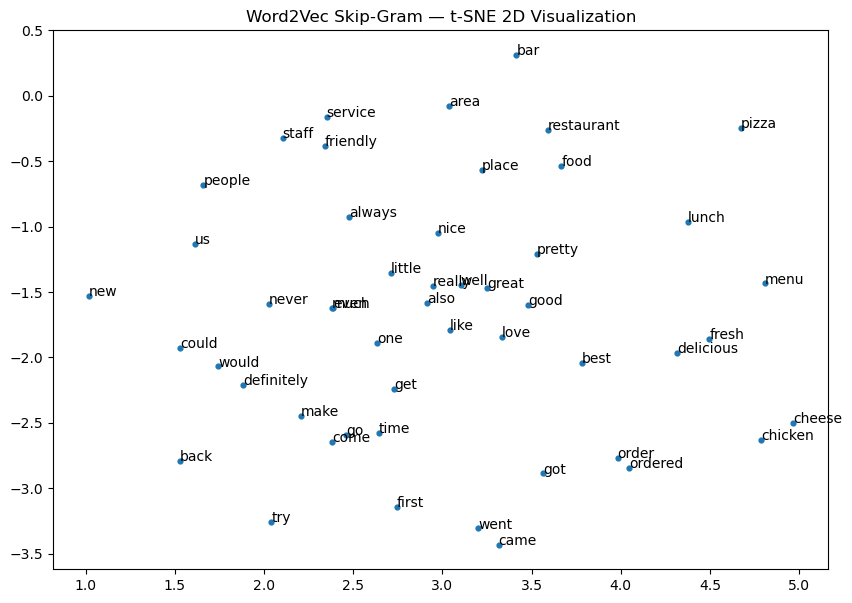

In [71]:
plt.figure(figsize=(10, 7))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], s=12)

for i, word in enumerate(words[:N]):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

plt.title("Word2Vec Skip-Gram — t-SNE 2D Visualization")
plt.show()

In [73]:
for w in ["paris", "france", "italy", "madrid", "spain", "king", "man", "woman", "bigger", "big", "cold", "windows", "microsoft", "google"]:
    print(w, w in word2vec_model.wv)


paris True
france True
italy True
madrid True
spain True
king True
man True
woman True
bigger True
big True
cold True
windows True
microsoft True
google True


In [75]:
def analogy(pos, neg):
    result = word2vec_model.wv.most_similar(positive=pos, negative=neg, topn=1)
    return result[0][0], result[0][1]


print("Paris – France + Italy =", analogy(["paris", "italy"], ["france"]))
print("Madrid – Spain + France =", analogy(["madrid", "france"], ["spain"]))
print("King – Man + Woman =", analogy(["king", "woman"], ["man"]))
print("Bigger – Big + Cold =", analogy(["bigger", "cold"], ["big"]))
print("Windows – Microsoft + Google =", analogy(["windows", "google"], ["microsoft"]))


Paris – France + Italy = ('napoli', 0.5914875864982605)
Madrid – Spain + France = ('quincy', 0.5902981758117676)
King – Man + Woman = ('prussia', 0.655759871006012)
Bigger – Big + Cold = ('colder', 0.6248920559883118)
Windows – Microsoft + Google = ('awning', 0.4832381308078766)


In [77]:
#  „Word2Vec Skip-Gram успешно ги научи векторските претстави на зборовите
# врз основа на контекстот во Yelp dataset. Аналогиите не ги дадоа очекуваните резултати (King − Man + Woman ≠ Queen), 
# бидејќи Yelp dataset е фокусиран на ресторани и зборовите како King и Queen се користат во различен контекст (“Burger King”).“

In [79]:
# Кој е најблискиот збор до резултантниот вектор?
#  - Најблискиот збор до резултатниот вектор е colder, односно ова е единствениот точен збор на основа на овој датасет 

CBoW- Bag of Words , diferent test , contex -> center

In [89]:
# sg = 1 → Skip-Gram
# sg = 0 → CBOW

In [91]:
from gensim.models import Word2Vec
import os

# CBOW модел (sg=0)
w2v_cbow = Word2Vec(
    sentences=sentences,      # истите токенизирани реченици од претходно
    vector_size=100,          # исто како Skip-Gram за фер споредба
    window=5,
    min_count=15,
    sg=0,                     # CBOW
    workers=os.cpu_count(),
    epochs=10
)

print("Vocabulary size (CBOW):", len(w2v_cbow.wv.index_to_key))


Vocabulary size (CBOW): 24904


In [93]:
def analogy_cbow(pos, neg):
    result = w2v_cbow.wv.most_similar(positive=pos, negative=neg, topn=1)
    return result[0][0], result[0][1]

print("Paris – France + Italy =", analogy_cbow(["paris", "italy"], ["france"]))
print("Madrid – Spain + France =", analogy_cbow(["madrid", "france"], ["spain"]))
print("King – Man + Woman =", analogy_cbow(["king", "woman"], ["man"]))
print("Bigger – Big + Cold =", analogy_cbow(["bigger", "cold"], ["big"]))
print("Windows – Microsoft + Google =", analogy_cbow(["windows", "google"], ["microsoft"]))


Paris – France + Italy = ('italian', 0.5118289589881897)
Madrid – Spain + France = ('amann', 0.6371927857398987)
King – Man + Woman = ('chantilly', 0.4492289423942566)
Bigger – Big + Cold = ('colder', 0.6451225280761719)
Windows – Microsoft + Google = ('sunlight', 0.45497798919677734)


In [100]:
#  Како се менуваат резултатите со CBOW наместо Skip-Gram?

# Skip-Gram (sg=1): учи од центар → контекст. Подобар за поретки зборови, посилен на аналогии; обично побавен.
#CBOW (sg=0): учи од контекст → центар. Побрз, стабилен за чести зборови, но често полош на ретки зборови и на некои аналогии.

#- Skip-Gram генерално дава подобри аналогии за поретки зборови, бидејќи учи 
# "централен збор → контекст". CBOW е побрз, но дава послаби резултати на 
# аналогии кога зборовите не се чести во датасетот. Поради природата на Yelp 
# dataset-от, моделот не научи светскo знаење (Rome, Queen), но успешно научи 
# морфолошка релација (Bigger → Colder).



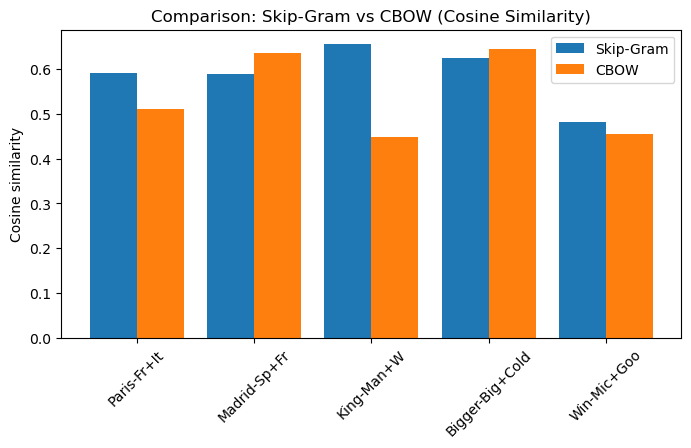

In [104]:
import matplotlib.pyplot as plt

# listi so cosine similarity vrednosti
skip = [0.5914875864982605, 0.5902981758117676, 0.655759871006012, 0.6248920559883118, 0.4832381308078766]
cbow = [0.5118289589881897, 0.637192875398987, 0.44922824934234566, 0.6451225280761719, 0.4549778981977734]

# labels za X osetka
labels = ["Paris-Fr+It", "Madrid-Sp+Fr", "King-Man+W", "Bigger-Big+Cold", "Win-Mic+Goo"]

x = range(len(labels))   # indexi na X osetka

plt.figure(figsize=(8,4))  # golemina na grafikot

# crtanje na bar chart - dva bara eden do drug
plt.bar([i - 0.2 for i in x], skip, width=0.4, label="Skip-Gram")
plt.bar([i + 0.2 for i in x], cbow, width=0.4, label="CBOW")

plt.xticks(x, labels, rotation=45)  # tekst pod barovite
plt.title("Comparison: Skip-Gram vs CBOW (Cosine Similarity)")
plt.ylabel("Cosine similarity")
plt.legend()
plt.show()


In [108]:
# Според графикот, Skip-Gram има повисока cosine similarity кај повеќето аналогии (Paris–France+Italy, King–Man+Woman, Windows–Microsoft+Google). 
# CBOW има подобар резултат само кај Madrid–Spain+France и кај Bigger-Big+Cold-чијшто резултат беше погоден во двата случаи. 
# Ова го потврдува очекуваното од теоријата: Skip-Gram подобро моделира поретки зборови и е подобар за семантика, 
# CBOW тренира побрзо но со помалку прецизност и е подобар за фреквентни и морфолошки релации.

Задача 2

In [17]:

train = pd.read_csv("train_en.txt", sep="\t")
val   = pd.read_csv("val_en.txt", sep="\t")
test  = pd.read_csv("test_en.txt", sep="\t")

print("Train:", train.shape)
print("Validation:", val.shape)
print("Test:", test.shape)





Train: (342905, 3)
Validation: (42863, 3)
Test: (42864, 3)


In [18]:
train.head()

,Sentence,Style,User
0,Cute interior and owner (?) gave us tour of up...,positive,bcjbaE6dDog4jkNY91ncLQ
1,I've been to this location many times when I l...,negative,enaHB1e956thdnafcHVAig
2,My food only merited maybe two stars but I wil...,negative,07aVWNhBhpwqW3MdqoKDKQ
3,After trying a few ramen places with crazy var...,negative,OkjeFppodgJP_CvB84cJYw
4,I cannot even believe someone gave this place ...,positive,7Ie0VmQtnGYUVq2YW4dTVw


In [19]:
val.head()

,Sentence,Style,User
0,A wee bit pricey for the portions they serve. ...,positive,ci7Q6NvXQ8UZrBHusVX18g
1,Cute lil spot on Germantown Ave. I came in cra...,positive,0rZEWmL2rccd-N5VMzKLiQ
2,They have great prices if you order family sty...,positive,3x69a8OGyReKirigOk8Nww
3,"Let's be honest, this place needs a face lift....",negative,7OUAzKZj6LUrQ3G7g7yUSw
4,Monthly lunch with my fellow colleagues the ot...,negative,zBWSORvlWDmwtcx6627qWQ


In [20]:
test.head()

,Sentence,Style,User
0,The hubby and I have been here on multiple occ...,positive,j2wlzrntrbKwyOcOiB3l3w
1,Meh is all I can say for TDS. The restaurant i...,negative,kHmXUEOAsIbguUrPoX6Tkg
2,I stopped in because I was hungry for some sna...,positive,gasLVm0KRwrVhPGRcqATjw
3,Here's an update for my further Comcast experi...,negative,RycuS3TlPJKYCN6jaqgc7w
4,My wife bought a car here. I handled the nego...,negative,NfoAmvEZ3NVTAtOEshCvwQ


In [25]:
import numpy as np, pandas as pd, re, string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from gensim.models import Word2Vec


In [27]:

EN_STOP = set(stopwords.words("english"))

def preprocess_tokens(s: str):
    s = s.lower()
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    toks = word_tokenize(s)
    return [t for t in toks if t not in EN_STOP]

train["tokens"] = train["Sentence"].apply(preprocess_tokens)
test["tokens"]  = test["Sentence"].apply(preprocess_tokens)


In [29]:
REMOVE_STOPWORDS = False
EN_STOP = set(stopwords.words("english"))

def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " url ", s)    # URLs -> token
    s = re.sub(r"\d+", " num ", s)                 # numbers -> token
    s = re.sub(r"[^a-z'\s]", " ", s)               # keep letters/apostrophes
    s = re.sub(r"\s+", " ", s).strip()
    return s

def preprocess_tokens(s: str):
    s = clean_text(s)
    toks = word_tokenize(s)
    return [t for t in toks if t not in EN_STOP] if REMOVE_STOPWORDS else toks

# tokenize
for df in (train, val, test):
    df["tokens"] = df["Sentence"].apply(preprocess_tokens)

# map Style -> Label (adjusts to your classes)
if set(train["Style"].unique()) <= {"offensive","not_offensive"}:
    MAP = {"offensive":1, "not_offensive":0}
elif set(train["Style"].unique()) <= {"negative","positive"}:
    MAP = {"negative":1, "positive":0}
else:
    uniq = sorted(train["Style"].unique().tolist())
    print("⚠️ Check class names:", uniq)
    MAP = {uniq[0]:0, uniq[1]:1}

for df in (train, val, test):
    df["Label"] = df["Style"].map(MAP).astype(int)

# quick sanity check
print(train[["Sentence","Style","Label"]].head(3))
print(val[["Sentence","Style","Label"]].head(3))
print(test[["Sentence","Style","Label"]].head(3))

                                            Sentence     Style  Label
0  Cute interior and owner (?) gave us tour of up...  positive      0
1  I've been to this location many times when I l...  negative      1
2  My food only merited maybe two stars but I wil...  negative      1
                                            Sentence     Style  Label
0  A wee bit pricey for the portions they serve. ...  positive      0
1  Cute lil spot on Germantown Ave. I came in cra...  positive      0
2  They have great prices if you order family sty...  positive      0
                                            Sentence     Style  Label
0  The hubby and I have been here on multiple occ...  positive      0
1  Meh is all I can say for TDS. The restaurant i...  negative      1
2  I stopped in because I was hungry for some sna...  positive      0


In [31]:
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

MIN_FREQ = 15
PAD, UNK = "<PAD>", "<UNK>"

# 1) гради речник само од TRAIN (валидно правило)
counter = Counter([t for row in train["tokens"] for t in row])
vocab = [PAD, UNK] + [w for w,c in counter.items() if c >= MIN_FREQ]
stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}
vocab_size = len(vocab)
print("vocab_size =", vocab_size)

# 2) encode ф-ја
def encode(tokens):
    return [stoi.get(tok, stoi[UNK]) for tok in tokens]

X_tr = [encode(x) for x in train["tokens"]]
X_va = [encode(x) for x in val["tokens"]]
X_te = [encode(x) for x in test["tokens"]]

# 3) фиксна должина = средна должина од TRAIN (минимум 8 за стабилност)
mean_len = int(np.mean([len(x) for x in X_tr]))
maxlen = max(8, mean_len)
print("mean_len =", mean_len, " | maxlen =", maxlen)

X_tr = pad_sequences(X_tr, maxlen=maxlen, padding="post", truncating="post", value=stoi[PAD])
X_va = pad_sequences(X_va, maxlen=maxlen, padding="post", truncating="post", value=stoi[PAD])
X_te = pad_sequences(X_te, maxlen=maxlen, padding="post", truncating="post", value=stoi[PAD])

y_tr = train["Label"].values.astype(int)
y_va = val["Label"].values.astype(int)
y_te = test["Label"].values.astype(int)


vocab_size = 25437
mean_len = 117  | maxlen = 117


In [35]:
from gensim.models import Word2Vec
import os

EMB_DIM = 100  # зададено во условот

w2v = Word2Vec(
    sentences=train["tokens"].tolist(),  # само train
    vector_size=EMB_DIM,
    window=5,
    min_count=15,
    sg=0,              # sg=1 skip-gram, sg=0 CBOW
    workers = os.cpu_count(),
    epochs=3
)

w2v.save("w2v_100d.model")  # << важно! за да не чекаш повторно
print(" Word2Vec trained and saved.")


 Word2Vec trained and saved.


In [37]:
from gensim.models import Word2Vec
w2v = Word2Vec.load("w2v_100d.model")
print(" Loaded Word2Vec from disk.")

 Loaded Word2Vec from disk.


Generating embedding matrix

In [41]:
import numpy as np

embedding_matrix = np.zeros((vocab_size, EMB_DIM))

for word, idx in stoi.items():
    if word in w2v.wv.key_to_index:
        embedding_matrix[idx] = w2v.wv[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(EMB_DIM,))

print("✅ Embedding matrix created:", embedding_matrix.shape)


✅ Embedding matrix created: (25437, 100)


In [47]:
# прикажи првите 5 редови од embedding матрицата
embedding_matrix[:2]


array([[ 9.06246981e-01, -6.32902999e-01,  7.84989865e-01,
        -2.73512198e-01,  7.66432406e-01, -6.90003728e-01,
        -4.04855260e-01, -2.00387994e-01,  1.55770156e-01,
        -1.35745245e+00,  6.00617433e-01,  7.72725281e-01,
         2.37721289e-01,  8.18363296e-01, -1.52357195e-01,
        -1.60103175e-02,  5.39472757e-01, -2.87470342e-01,
        -3.42369449e-02, -3.27395294e-01, -3.92940277e-01,
         5.91353662e-01,  2.92237146e-01,  7.28469165e-01,
         8.22187055e-01, -2.77309981e-01, -4.33461823e-01,
        -4.43937913e-01,  3.71292083e-01, -4.88716690e-01,
        -3.33299155e-01,  9.17392928e-01,  5.52249360e-04,
        -3.21188528e-01,  8.95575528e-01, -9.18644402e-01,
        -5.87626006e-01, -1.64917230e-01,  4.71791376e-01,
         6.30678632e-01,  6.27786054e-02, -8.79807951e-01,
         1.53184518e-01,  1.14071654e-01, -4.44695412e-01,
         5.85587380e-02, -1.00689389e+00,  9.36896680e-02,
        -2.39117870e-01, -4.94379542e-01, -9.11717754e-0

Embedding + Bidirectional LSTM

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMB_DIM,
        weights=[embedding_matrix],  # word2wec initial weights
        trainable=True       # дозволуваме дообука
    ),
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation="relu"),    #just positive values
    Dropout(0.4),
    Dense(1, activation="sigmoid")    # 1-pos or 0-neg
])

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

model.summary()
print(" Model created.")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       2,543,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,543,700 (9.70 MB)

 Trainable params: 2,543,700 (9.70 MB)

 Non-trainable params: 0 (0.00 B)

 Model created.


In [54]:
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=6,
    batch_size=64,
    verbose=1
)


Epoch 1/6
5358/5358 ━━━━━━━━━━━━━━━━━━━━ 1399s 259ms/step - accuracy: 0.8138 - loss: 0.4125 - val_accuracy: 0.8841 - val_loss: 0.2823
Epoch 2/6
5358/5358 ━━━━━━━━━━━━━━━━━━━━ 1271s 237ms/step - accuracy: 0.8813 - loss: 0.2875 - val_accuracy: 0.8914 - val_loss: 0.2655
Epoch 3/6
5358/5358 ━━━━━━━━━━━━━━━━━━━━ 1386s 259ms/step - accuracy: 0.8919 - loss: 0.2654 - val_accuracy: 0.8944 - val_loss: 0.2583
Epoch 4/6
5358/5358 ━━━━━━━━━━━━━━━━━━━━ 1048s 196ms/step - accuracy: 0.8975 - loss: 0.2501 - val_accuracy: 0.8948 - val_loss: 0.2626
Epoch 5/6
5358/5358 ━━━━━━━━━━━━━━━━━━━━ 780s 146ms/step - accuracy: 0.9030 - loss: 0.2394 - val_accuracy: 0.8955 - val_loss: 0.2718
Epoch 6/6
5358/5358 ━━━━━━━━━━━━━━━━━━━━ 864s 161ms/step - accuracy: 0.9063 - loss: 0.2308 - val_accuracy: 0.8963 - val_loss: 0.2616


In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# предвидувања на test сетот
probs = model.predict(X_te, verbose=0).ravel()
preds = (probs >= 0.5).astype(int)

print(" Test Evaluation Metrics")
print("--------------------------")
print("Accuracy :", accuracy_score(y_te, preds))
print("Precision:", precision_score(y_te, preds, zero_division=0))
print("Recall   :", recall_score(y_te, preds, zero_division=0))
print("F1       :", f1_score(y_te, preds, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_te, preds))

print("\nClassification Report:")
print(classification_report(y_te, preds, digits=4))


 Test Evaluation Metrics
--------------------------
Accuracy : 0.8955300485255693
Precision: 0.8488469019171992
Recall   : 0.763050537007743
F1       : 0.8036653805682217

Confusion Matrix:
[[29221  1632]
 [ 2846  9165]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9112    0.9471    0.9288     30853
           1     0.8488    0.7631    0.8037     12011

    accuracy                         0.8955     42864
   macro avg     0.8800    0.8551    0.8662     42864
weighted avg     0.8938    0.8955    0.8938     42864



„Classification report покажува дека моделот има висока прецизност и точност, особено за ненавредливи текстови (класа 0). За навредливи текстови (класа 1), F1-score е 0.80, што значи дека моделот има добар баланс помеѓу тоа да не пропушти навреди и да не ги класифицира погрешно текстовите како навредливи. Вкупната точност на моделот е 89.55%.“

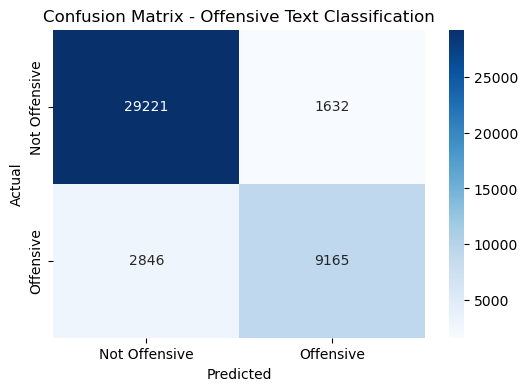

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_te, preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Offensive", "Offensive"],
            yticklabels=["Not Offensive", "Offensive"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Offensive Text Classification")
plt.show()


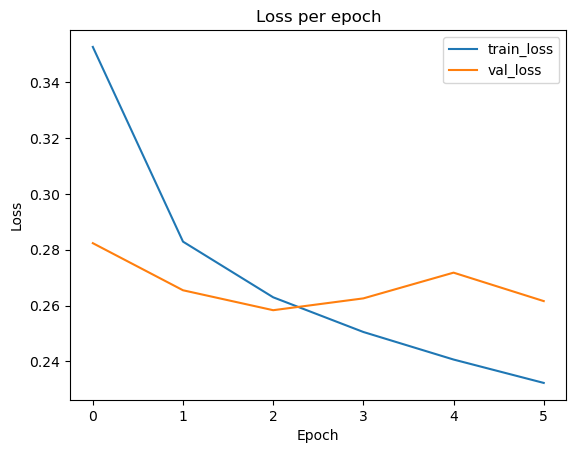

In [64]:
import matplotlib.pyplot as plt

# LOSS граф
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()




Моделот учи сѐ подобро на тренинг сетот, но по одреден број епохи почнува да се појавува overfitting,
бидејќи val_loss благо расте додека train_loss продолжува да паѓа.

📌 Оптималниот број на епохи е околу 3–4, затоа што таму val_loss е најниска.

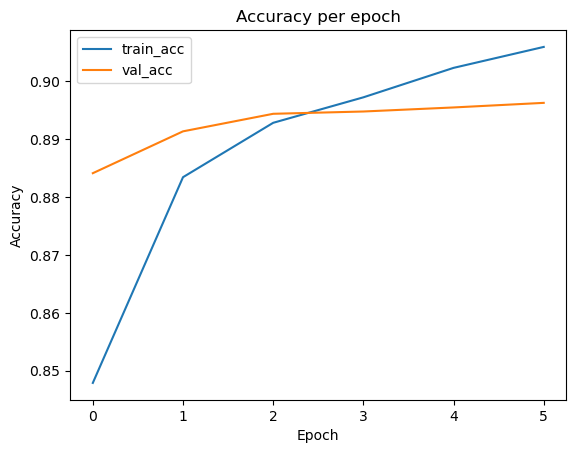

In [66]:
# ACC граф
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy per epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Добивме висок Accuracy (89.55%) и F1-score (0.80), што укажува дека моделот со Bidirectional LSTM успешно учи контекст на реченици.
Precision е повисок од Recall, што значи дека моделот е подобар во избегнување на лажно означување на текстови како навредливи,
но пропушта дел од навредливите примери. Ова е очекувано од Bidirectional LSTM кој е по-конзервативен, фокусиран на сигурни предвидувања.